In [8]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np

def extract_thd_values(file_path):
    """
    Extracts the THD (%) values from the given file.

    Parameters:
    - file_path (str): Path to the input file.

    Returns:
    - List[float]: List of THD (%) values.
    """
    # Read the first few lines to determine the THD column index
    with open(file_path, 'r') as file:
        headers_line = [file.readline().strip() for _ in range(7)][6]

    headers = headers_line.split()
    thd_index = next((i for i, header in enumerate(headers) if "THD" in header), None)
    # If the index is found and it's not the last header, we adjust to get the correct column index
    if thd_index is not None and thd_index < len(headers) - 1 and "(%)" in headers[thd_index + 1]:
        thd_index += 1
    
    freq_index = 0

    freqs = []
    thd_values = []
    with open(file_path, 'r') as file:
        # Skip the header lines
        for _ in range(7):
            file.readline()

        # Read and parse the rest of the lines
        for line in file:
            values = line.split()
            freqs.append(float(values[freq_index]))
            thd_values.append(float(values[thd_index]))
    
    return freqs, thd_values

In [9]:
# get all txts under the working directory
txts = []
for root, dirs, files in os.walk("./Used for plotting"):
    for file in files:
        if file.endswith(".txt"):
            txts.append(os.path.join(root, file))

measurement_dict = {}

for txt in txts:
    name = txt.split("/")[-1].split(".txt")[0]
    if measurement_dict.get(name) is None:
        measurement_dict[name] = {}
    freqs, thds = extract_thd_values(txt)
    measurement_dict[name] = {
        "freqs": freqs,
        "thds": thds
    }

print(measurement_dict)

{'Burl Audio B1D': {'freqs': [20.0, 20.586, 21.189, 21.81, 22.449, 23.107, 23.784, 24.481, 25.198, 25.937, 26.697, 27.479, 28.284, 29.113, 29.966, 30.844, 31.748, 32.678, 33.636, 34.621, 35.636, 36.68, 37.755, 38.861, 40.0, 41.172, 42.379, 43.62, 44.898, 46.214, 47.568, 48.962, 50.397, 51.874, 53.394, 54.958, 56.569, 58.226, 59.932, 61.688, 63.496, 65.357, 67.272, 69.243, 71.272, 73.36, 75.51, 77.723, 80.0, 82.344, 84.757, 87.241, 89.797, 92.428, 95.137, 97.924, 100.794, 103.747, 106.787, 109.916, 113.137, 116.452, 119.865, 123.377, 126.992, 130.713, 134.543, 138.486, 142.544, 146.721, 151.02, 155.445, 160.0, 164.688, 169.514, 174.481, 179.594, 184.856, 190.273, 195.849, 201.587, 207.494, 213.574, 219.833, 226.274, 232.905, 239.729, 246.754, 253.984, 261.426, 269.087, 276.972, 285.088, 293.441, 302.04, 310.89, 320.0, 329.377, 339.028, 348.962, 359.188, 369.713, 380.546, 391.697, 403.175, 414.989, 427.149, 439.665, 452.548, 465.809, 479.458, 493.507, 507.968, 522.853, 538.174, 553.943, 

In [10]:
# align the amplitude to the closest frequency to 1k
for name, measurements in measurement_dict.items():
    for measurement in measurements:
        frequency = measurement['frequency']
        amplitude = measurement['amplitude']
        phase = measurement['phase']
        idx = np.abs(frequency - 1000).argmin()
        amplitude_normalized = amplitude - amplitude[idx]
        phase_normalized = phase - phase[idx]
        measurement['amplitude'] = amplitude_normalized
        measurement['phase'] = phase_normalized

# average all measurements
averaged_measurement_dict = {}
for name, measurements in measurement_dict.items():
    averaged_measurement_dict[name] = {
        'frequency': measurements[0]['frequency'],
        'amplitude': np.zeros(len(measurements[0]['amplitude'])),
        'phase': np.zeros(len(measurements[0]['phase']))
    }
    for measurement in measurements:
        averaged_measurement_dict[name]['amplitude'] += measurement['amplitude']
        averaged_measurement_dict[name]['phase'] += measurement['phase']
    averaged_measurement_dict[name]['amplitude'] /= len(measurements)
    averaged_measurement_dict[name]['phase'] /= len(measurements)

# use "Cal" to calibrate all
cal = averaged_measurement_dict['Cal']
for name, measurements in averaged_measurement_dict.items():
    if name == 'Cal' or name == 'Tegeler' or name == 'Vertigo Sound VSP-2':
        continue
    measurements['amplitude'] -= cal['amplitude']
    measurements['phase'] -= cal['phase']

# remove cal from averaged_measurement_dict
del averaged_measurement_dict['Cal']

TypeError: string indices must be integers

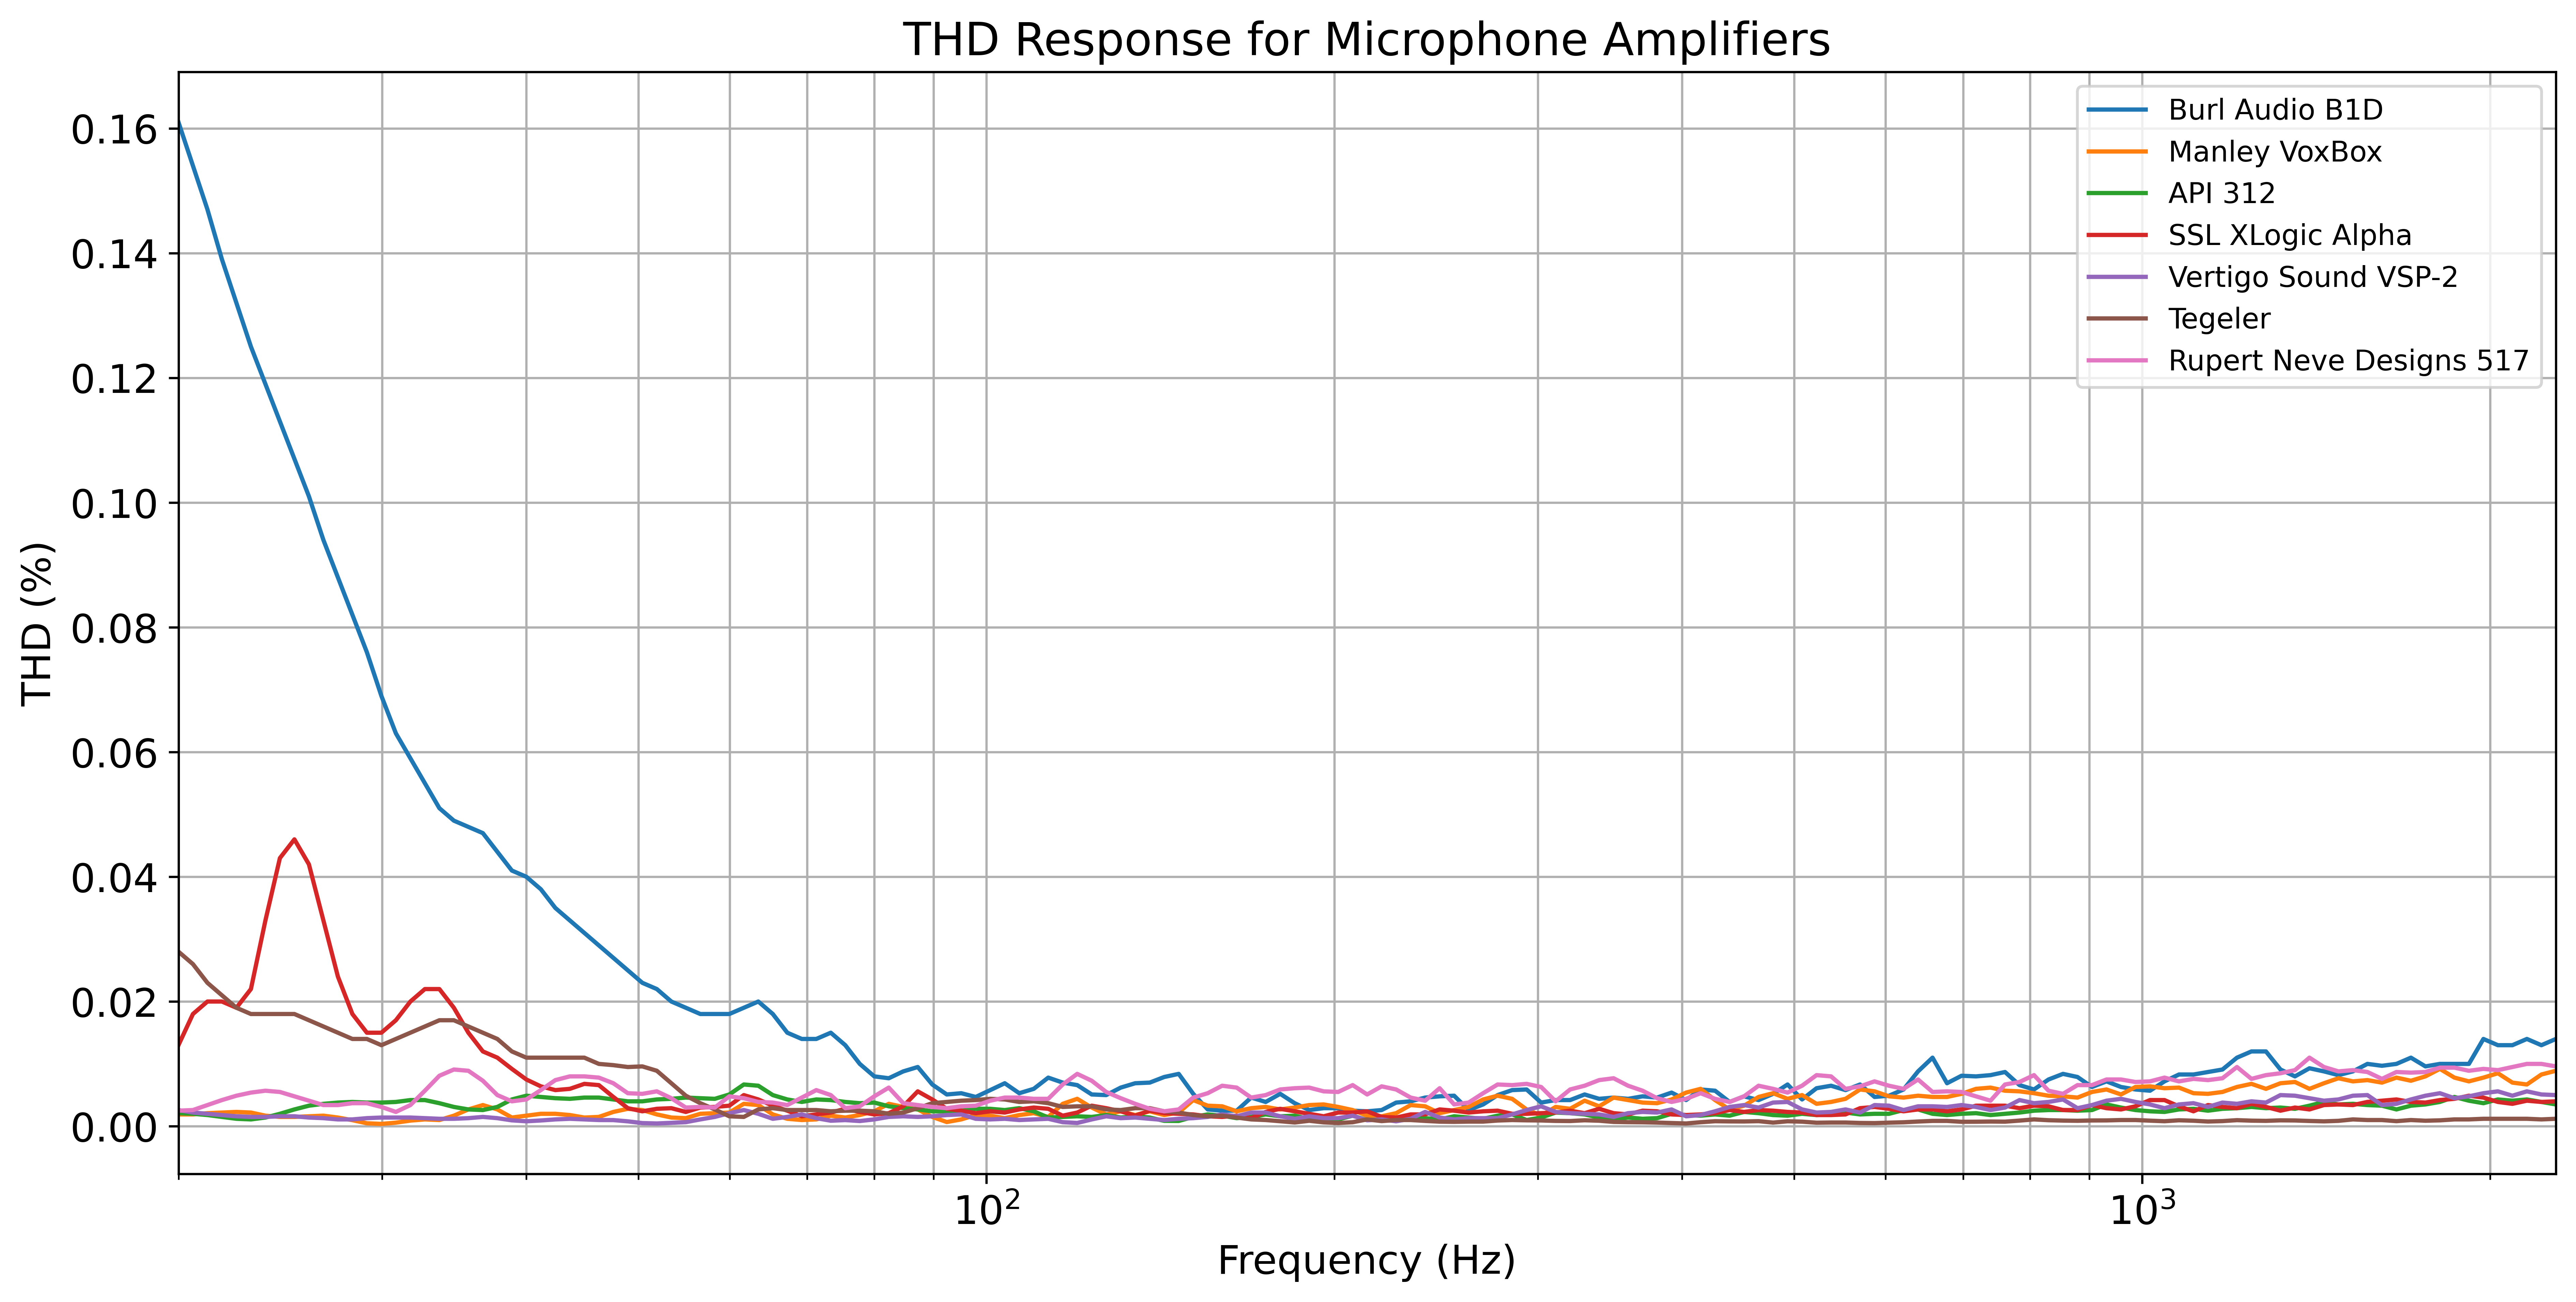

In [12]:
# plot frequency vs amplitude. name is legend
fig = plt.figure()
# set size
fig.set_size_inches(15, 7)
# set dpi
fig.set_dpi(600)
ax = fig.add_subplot(111)
ax.set_title('THD Response for Microphone Amplifiers', fontsize=16)
for name, measurements in measurement_dict.items():
    ax.plot(measurements['freqs'], measurements['thds'], label=name)
    ax.set_xlabel('Frequency (Hz)', fontsize=14)
    ax.set_ylabel('THD (%)', fontsize=14)
    ax.legend()

plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(which='both')
plt.xscale('log')
plt.xlim(20, 2280)
# plt.ylim(-10, 1)
plt.show()